In [1]:
import tensorflow as tf
class ConvBlock(tf.keras.models.Sequential):
    def __init__(self):
        super(ConvBlock, self).__init__(
            [
                tf.keras.Input((84,84,4)),
                tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32) / 255.0 ),
                tf.keras.layers.Conv2D(64, 5, padding="same", activation="relu", strides=2),
                tf.keras.layers.Conv2D(128, 5, padding="same", activation="relu", strides=2),
                tf.keras.layers.Conv2D(128, 5, padding="same", activation="relu", strides=2),
                tf.keras.layers.Conv2D(256, 5, padding="same", activation="relu", strides=2),
                tf.keras.layers.GlobalAveragePooling2D(),
            ]
        )

In [11]:
from ncps.tf import CfC
class ConvCfC(tf.keras.Model):
    def __init__(self, n_actions):
        super().__init__()
        self.conv_block = ConvBlock()
        self.td_conv = tf.keras.layers.TimeDistributed(self.conv_block)
        self.rnn = CfC(64, return_sequences = True, return_state=True)
        self.linear = tf.keras.layers.Dense(n_actions)
    def get_initial_states(self, batch_size = 1):
        return self.rnn.cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
    def call(self, x , training=None, **kwargs):
        has_hx = isinstance(x, list) or isinstance(x, tuple)
        initial_state = None
        if has_hx:
            x, initial_state = x
        x = self.td_conv(x, training=training)
        x, next_state = self.rnn(x, initial_state= initial_state)
        x = self.linear(x)
        if has_hx:
            return(x, next_state)
        return x
        

In [3]:
import gym
import ale_py
from ray.rllib.env.wrappers.atari_wrappers import wrap_deepmind
import numpy as np

env = gym.make("ALE/Breakout-v5")
env = wrap_deepmind(env)


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
2023-05-21 11:12:43,776	WARNING deprecation.py:47 -- DeprecationWarning: `FrameStack` has been deprecated. This will raise an error in the future!


In [4]:
from ncps.datasets.tf import AtariCloningDatasetTF

data = AtariCloningDatasetTF('breakout')
#batch size 32
trainloader = data.get_dataset(32, split="train")
valloader = data.get_dataset(32, split="val")

In [12]:
def run_closed_loop(model, env, num_episodes=None):
    obs = env.reset()
    hx = model.get_initial_states()
    returns = []
    total_reward = 0
    while True:
        obs = np.expand_dims(np.expand_dims(obs,0), 0)
        pred , hx = model.predict((obs, hx), verbose=0)
        action = pred[0,0].argmax()
        obs, r, done, _ = env.step(action)
        total_reward += r
        if done:
            returns.append(total_reward)
            total_reward = 0
            obs = env.reset()
            hx = model.get_initial_states()
            if num_episodes is not None:
                num_episodes = num_episodes - 1
                if num_episodes == 0:
                    return returns

In [13]:
class ClosedLoopCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, env):
        super().__init__()
        self.model = model
        self.env = env
    def on_epoch_end(self, epoch, logs=None):
        r = run_closed_loop(self.model, self.env, num_episodes = 10)
        print(f"\nEpoch {epoch} return: {np.mean(r):0.2f} +- {np.std(r):0.2f}")

In [15]:
#training
model = ConvCfC(env.action_space.n)
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(0.001),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
)
model.build((None, None, 84,84, 4))
model.summary()

model.fit(trainloader, epochs=50, validation_data=valloader, callbacks=[ClosedLoopCallback(model, env)],)

Model: "conv_cf_c_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_block_3 (ConvBlock)    (None, 256)               1440576   
                                                                 
 time_distributed_3 (TimeDis  multiple                 1440576   
 tributed)                                                       
                                                                 
 cf_c_3 (CfC)                multiple                  74112     
                                                                 
 dense_3 (Dense)             multiple                  260       
                                                                 
Total params: 1,514,948
Trainable params: 1,514,948
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 68/938 [=>............................] - ETA: 8:23:52 - loss: 0.6371 - sparse_categorical_accuracy

KeyboardInterrupt: 

In [6]:
# !pip3 install ncps tensorflow "ale-py==0.7.4" "ray[rllib]==2.1.0" "gym[atari,accept-rom-license]==0.23.1"
# Copyright 2022 Mathias Lechner
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import tensorflow as tf
import gym
import ale_py
from ray.rllib.env.wrappers.atari_wrappers import wrap_deepmind
from ncps.tf import CfC
import numpy as np
from ncps.datasets.tf import AtariCloningDatasetTF


# Not used in this example
class ConvBlock(tf.keras.models.Sequential):
    def __init__(self):
        super(ConvBlock, self).__init__(
            [
                tf.keras.Input((84, 84, 4)),
                tf.keras.layers.Lambda(
                    lambda x: tf.cast(x, tf.float32) / 255.0
                ),  # normalize input
                tf.keras.layers.Conv2D(
                    64, 5, padding="same", activation="relu", strides=2
                ),
                tf.keras.layers.Conv2D(
                    128, 5, padding="same", activation="relu", strides=2
                ),
                tf.keras.layers.Conv2D(
                    128, 5, padding="same", activation="relu", strides=2
                ),
                tf.keras.layers.Conv2D(
                    256, 5, padding="same", activation="relu", strides=2
                ),
                tf.keras.layers.GlobalAveragePooling2D(),
            ]
        )


class ImpalaConvLayer(tf.keras.models.Sequential):
    def __init__(self, filters, kernel_size, strides, padding="valid", use_bias=False):
        super(ImpalaConvLayer, self).__init__(
            [
                tf.keras.layers.Conv2D(
                    filters=filters,
                    kernel_size=kernel_size,
                    strides=strides,
                    padding=padding,
                    use_bias=use_bias,
                    kernel_initializer=tf.keras.initializers.VarianceScaling(
                        scale=2.0, mode="fan_out", distribution="truncated_normal"
                    ),
                ),
                tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001),
                tf.keras.layers.ReLU(),
            ]
        )


class ImpalaConvBlock(tf.keras.models.Sequential):
    def __init__(self):
        super(ImpalaConvBlock, self).__init__(
            [
                ImpalaConvLayer(filters=16, kernel_size=8, strides=4),
                ImpalaConvLayer(filters=32, kernel_size=4, strides=2),
                ImpalaConvLayer(filters=32, kernel_size=3, strides=1),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(units=256, activation="relu"),
            ]
        )


class ConvCfC(tf.keras.Model):
    def __init__(self, n_actions):
        super().__init__()
        self.conv_block = ImpalaConvBlock()
        self.td_conv = tf.keras.layers.TimeDistributed(self.conv_block)
        self.rnn = CfC(64, return_sequences=True, return_state=True)
        self.linear = tf.keras.layers.Dense(n_actions)

    def get_initial_states(self, batch_size=1):
        return self.rnn.cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)

    def call(self, x, training=None, **kwargs):
        has_hx = isinstance(x, list) or isinstance(x, tuple)
        initial_state = None
        if has_hx:
            # additional inputs are passed as a tuple
            x, initial_state = x

        x = self.td_conv(x, training=training)
        x, next_state = self.rnn(x, initial_state=initial_state)
        x = self.linear(x)
        if has_hx:
            return (x, next_state)
        return x

import matplotlib.pyplot as plt

def run_closed_loop(model, env, num_episodes=None):
    obs = env.reset()
    hx = model.get_initial_states()
    returns = []
    total_reward = 0
    while True:
        # add batch and time dimension (with a single element in each)
        plt.imshow(obs)
        plt.axis('off')
        plt.show()
        obs = np.expand_dims(np.expand_dims(obs, 0), 0)
        pred, hx = model.predict((obs, hx), verbose=0)
        action = pred[0, 0].argmax()
        # remove time and batch dimension -> then argmax
        obs, r, done, _ = env.step(action)
        print("reward ", r)
        total_reward += r
        if done:
            returns.append(total_reward)
            total_reward = 0
            obs = env.reset()
            hx = model.get_initial_states()
            # Reset RNN hidden states when episode is over
            if num_episodes is not None:
                # Count down the number of episodes
                num_episodes = num_episodes - 1
                if num_episodes == 0:
                    return returns


class ClosedLoopCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, env):
        super().__init__()
        self.model = model
        self.env = env

    def on_epoch_end(self, epoch, logs=None):
        r = run_closed_loop(self.model, self.env, num_episodes=10)
        print(f"\nEpoch {epoch} return: {np.mean(r):0.2f} +- {np.std(r):0.2f}")


if __name__ == "__main__":
    env = gym.make("ALE/Breakout-v5")
    env = wrap_deepmind(env)

    # data = AtariCloningDatasetTF("breakout")
    # batch size 32
    # trainloader = data.get_dataset(32, split="train")
    # valloader = data.get_dataset(32, split="val")

    model1 = ConvCfC(env.action_space.n)

    model1.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.0001),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )
    
    model1.build((None, None, 84, 84, 4))
    model1.summary()
    model1.load_weights("models/breakout/model_ALE_Breakout_Impala.h5")
    # model1.fit(
    #     trainloader,
    #     epochs=50,
    #     validation_data=valloader,
    #     callbacks=[ClosedLoopCallback(model, env)],
    # )

    # Visualize Atari game and play endlessly
    # env = gym.make("ALE/Breakout-v5", render_mode="human")
    # env = wrap_deepmind(env)
    # run_closed_loop(model, env)

Model: "conv_cf_c_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 impala_conv_block_1 (Impala  (None, 256)              423488    
 ConvBlock)                                                      
                                                                 
 time_distributed_1 (TimeDis  multiple                 423488    
 tributed)                                                       
                                                                 
 cf_c_1 (CfC)                multiple                  74112     
                                                                 
 dense_3 (Dense)             multiple                  260       
                                                                 
Total params: 497,860
Trainable params: 497,700
Non-trainable params: 160
_________________________________________________________________


In [ ]:
# Visualize Atari game and play endlessly
import matplotlib.pyplot as plt

def run_closed_loop(model, env, num_episodes=None):
    obs = env.reset()
    hx = model.get_initial_states()
    returns = []
    total_reward = 0
    while True:
        # add batch and time dimension (with a single element in each)
        plt.imshow(obs)
        plt.axis('off')
        plt.show()
        obs = np.expand_dims(np.expand_dims(obs, 0), 0)
        pred, hx = model.predict((obs, hx), verbose=0)
        action = pred[0, 0].argmax()
        # remove time and batch dimension -> then argmax
        obs, r, done, _ = env.step(action)
        print("reward ", r)
        total_reward += r
        if done:
            returns.append(total_reward)
            total_reward = 0
            obs = env.reset()
            hx = model.get_initial_states()
            # Reset RNN hidden states when episode is over
            if num_episodes is not None:
                # Count down the number of episodes
                num_episodes = num_episodes - 1
                if num_episodes == 0:
                    return returns

model1 = ConvCfC(env.action_space.n)

model1.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
model1.build((None, None, 84, 84, 4))
model1.load_weights("models/breakout/model_ALE_Breakout_Impala.h5")

env = gym.make("ALE/Breakout-v5")
env = wrap_deepmind(env)
run_closed_loop(model1, env, num_episodes=1)

In [39]:
!ls models/breakout

model_ALE_Breakout_Impala.h5


In [12]:
model1.load_weights("models/breakout/model_ALE_Breakout_Impala.h5")

ValueError: Unable to load weights saved in HDF5 format into a subclassed Model which has not created its variables yet. Call the Model first, then load the weights.

In [21]:
data.get_dataset(1, split="train").

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 84, 84, 4), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 32), dtype=tf.int64, name=None))>

In [28]:
a =  [1,2,3,4,5,6,7,8,9,10,50,100]

In [29]:
np.std((np.array(a)))

27.96264869825858

In [ ]:
import tensorflow as tf

def create_prefetch_dataset():
    # Define the shape and data types for the tensors
    tensor_shape = (None, 32, 84, 84, 4)
    tensor_dtype = tf.uint8
    label_shape = (None, 32)
    label_dtype = tf.int64

    # Create example tensors
    example_data = tf.zeros(tensor_shape, dtype=tensor_dtype)
    example_labels = tf.zeros(label_shape, dtype=label_dtype)

    # Create a dataset from the tensors
    dataset = tf.data.Dataset.from_tensor_slices((example_data, example_labels))

    # Apply any necessary transformations to the dataset

    # Prefetch the dataset
    prefetched_dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return prefetched_dataset
create_prefetch_dataset()

In [31]:
import tensorflow as tf

def create_prefetch_dataset():
    # Define the shape and data types for the tensors
    tensor_shape = (32, 84, 84, 4)
    tensor_dtype = tf.uint8
    label_shape = (32,)
    label_dtype = tf.int64

    # Create example tensors
    example_data = tf.zeros(tensor_shape, dtype=tensor_dtype)
    example_labels = tf.zeros(label_shape, dtype=label_dtype)

    # Create a dataset from the tensors
    dataset = tf.data.Dataset.from_tensor_slices((example_data, example_labels))

    # Apply any necessary transformations to the dataset

    # Prefetch the dataset
    prefetched_dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return prefetched_dataset


In [33]:
import tensorflow as tf

def create_prefetch_dataset():
    # Define the shape and data types for the tensors
    tensor_shape = (None, 32, 84, 84, 4)
    tensor_dtype = tf.uint8
    label_shape = (None, 32)
    label_dtype = tf.int64

    # Create example tensors
    example_data = tf.zeros(tensor_shape, dtype=tensor_dtype)
    example_labels = tf.zeros(label_shape, dtype=label_dtype)

    # Create a dataset from the tensors
    dataset = tf.data.Dataset.from_tensor_slices((example_data, example_labels))

    # Apply any necessary transformations to the dataset

    # Prefetch the dataset
    prefetched_dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return prefetched_dataset


In [34]:
create_prefetch_dataset()

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [35]:
import numpy as np

mean_return = 40.10
std_deviation = 71.09

# Generate a list of return values
returns = np.random.normal(loc=mean_return, scale=std_deviation, size=10)

# Print the list of returns
print(returns)


[-117.92977953    1.14790585   77.50750797  -41.50813684  -11.4591752
  -32.21841112   29.62444375   -4.95189607   34.24455897   10.24548834]


In [36]:
import numpy as np

mean_return = 40.10
std_deviation = 71.09

# Generate a list of positive return values
returns = np.random.exponential(scale=std_deviation, size=10) + mean_return

# Print the list of returns
print(returns)


[ 62.89609568 224.0843604   70.91951411  71.68459125  45.23568753
 155.34361081  74.62406192  81.54988349  40.74849762  62.47888553]


In [9]:
env.action_space.n

4

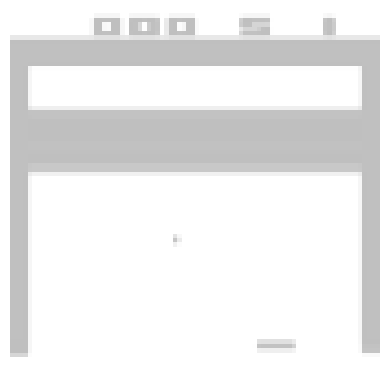

reward  0.0


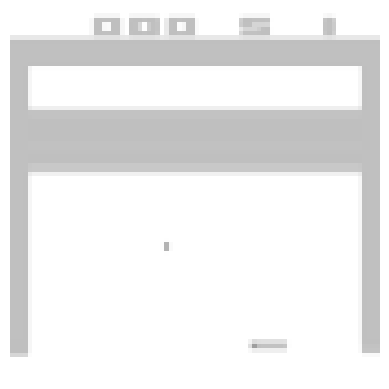

reward  0.0


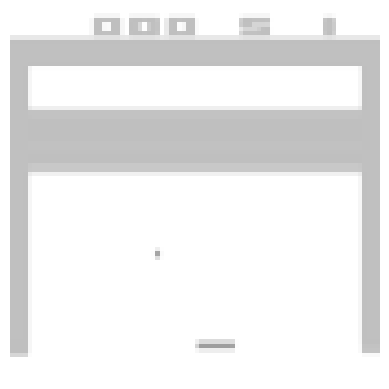

reward  0.0


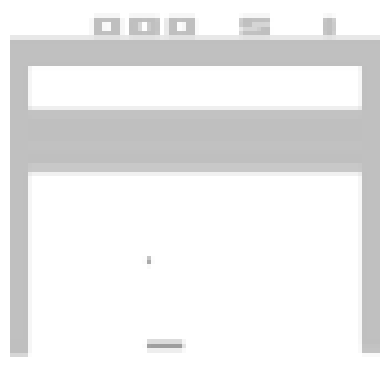

reward  0.0


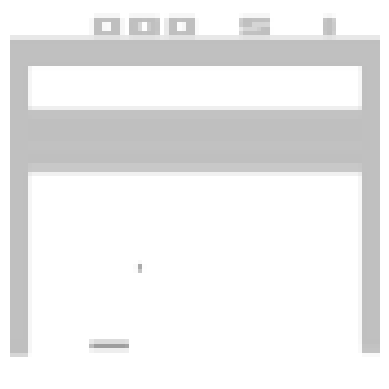

reward  0.0


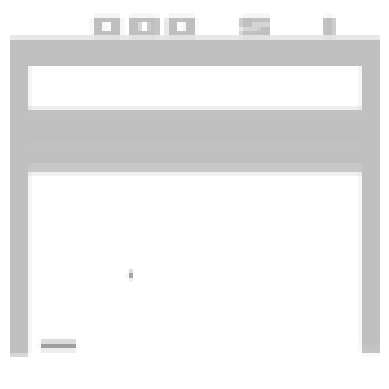

reward  0.0


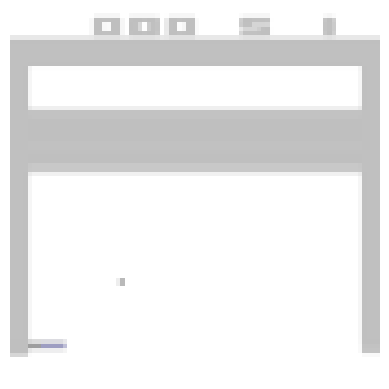

reward  0.0


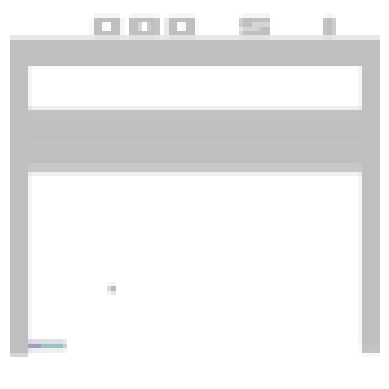

reward  0.0


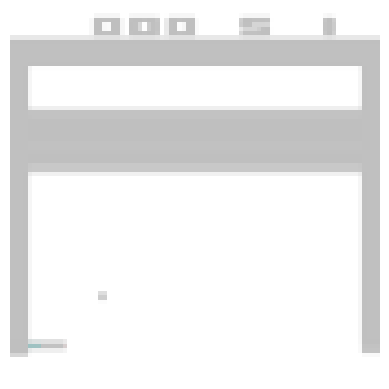

reward  0.0


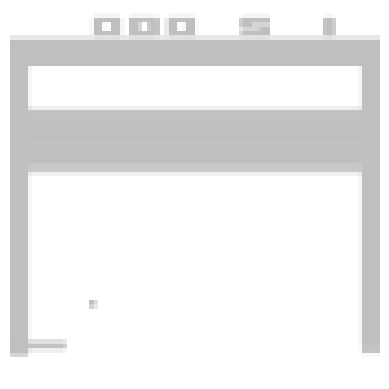

reward  0.0


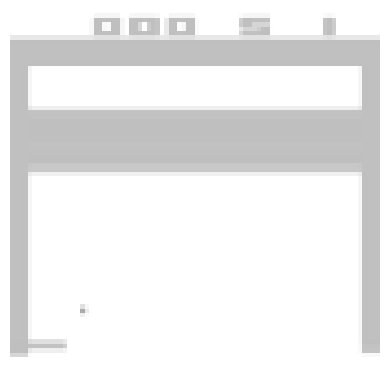

reward  0.0


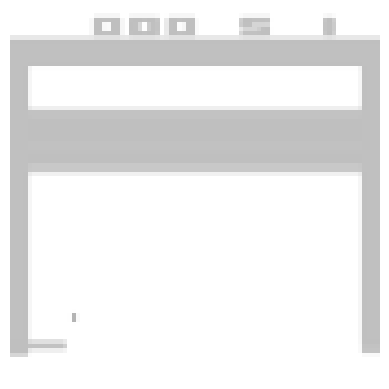

reward  0.0


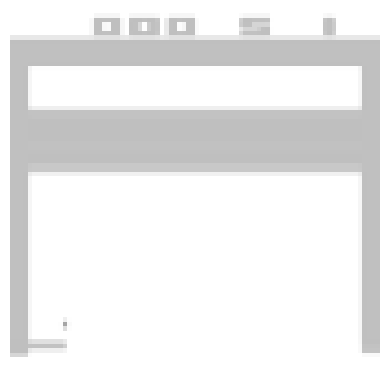

reward  0.0


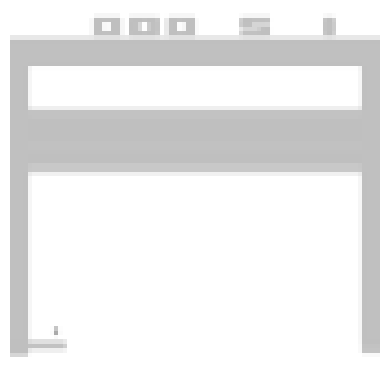

reward  0.0


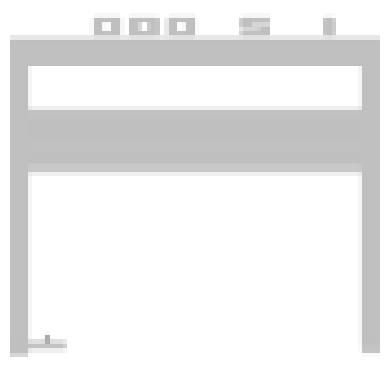

reward  0.0


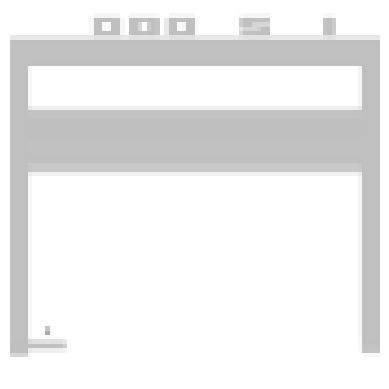

reward  0.0


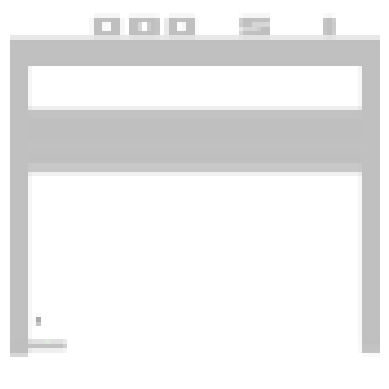

reward  0.0


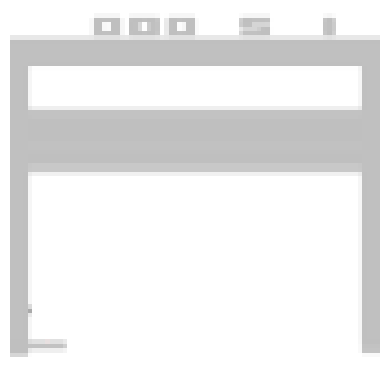

reward  0.0


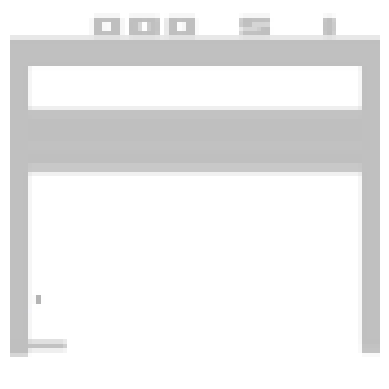

reward  0.0


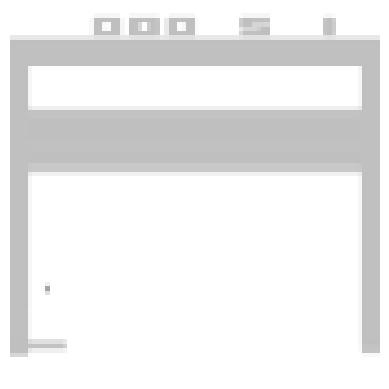

reward  0.0


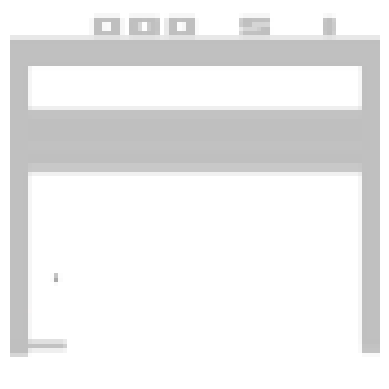

reward  0.0


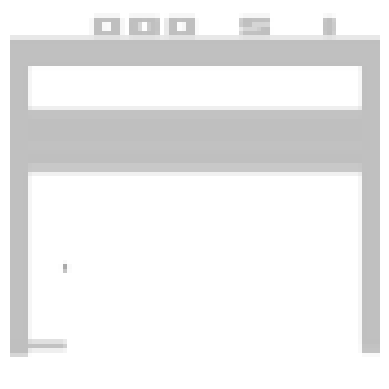

reward  0.0


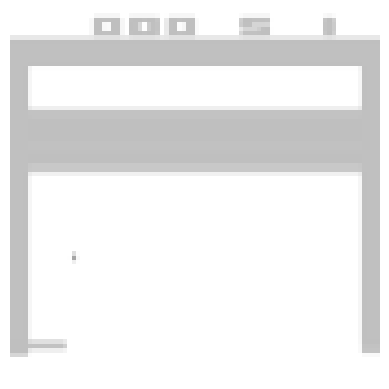

reward  0.0


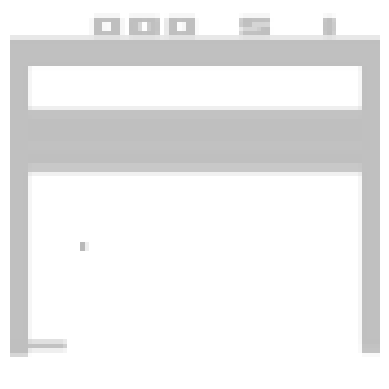

reward  0.0


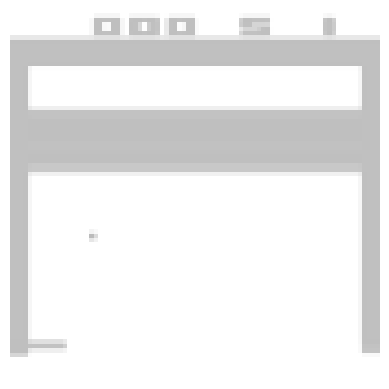

reward  0.0


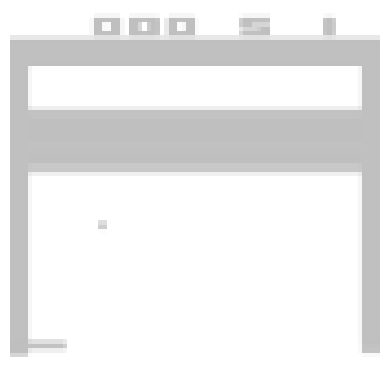

reward  0.0


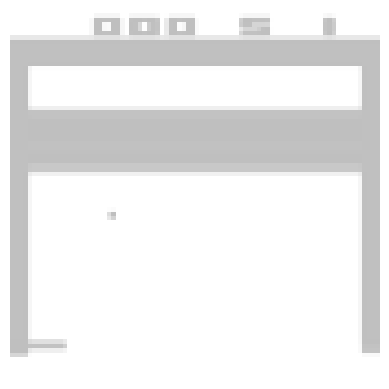

reward  0.0


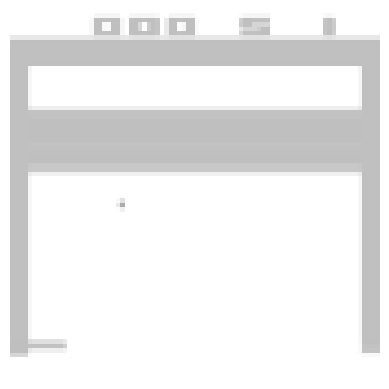

reward  0.0


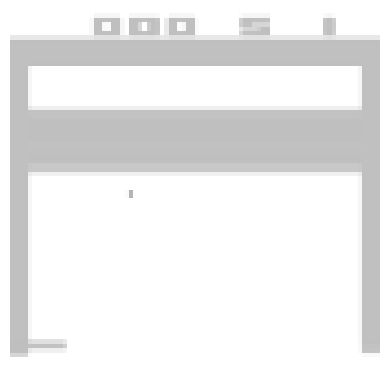

reward  0.0


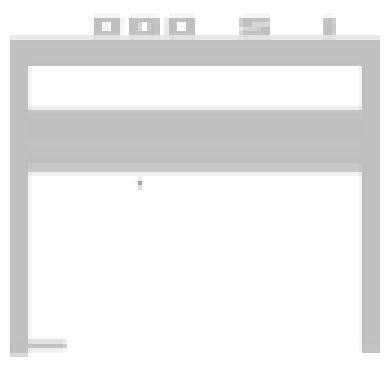

reward  1.0


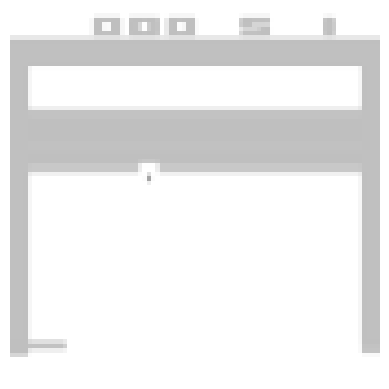

reward  0.0


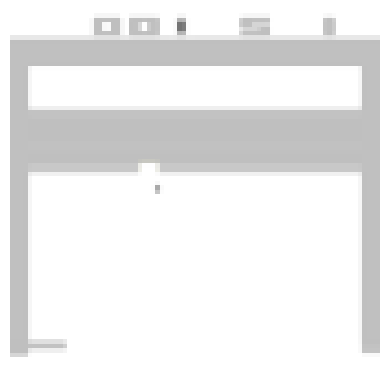

reward  0.0


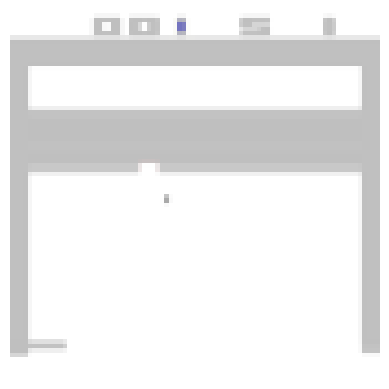

reward  0.0


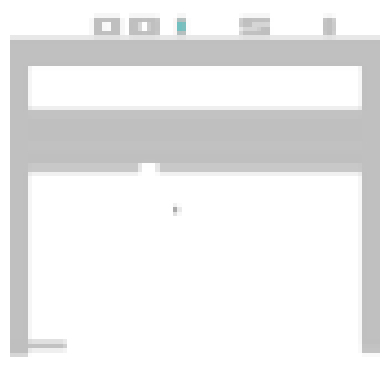

reward  0.0


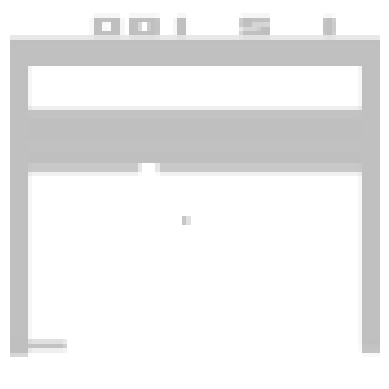

reward  0.0


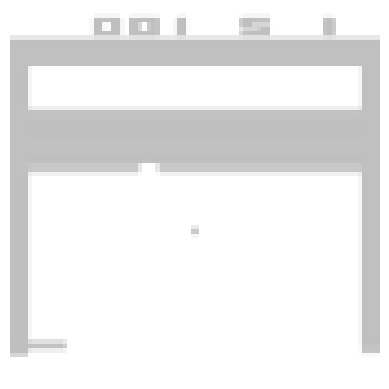

reward  0.0


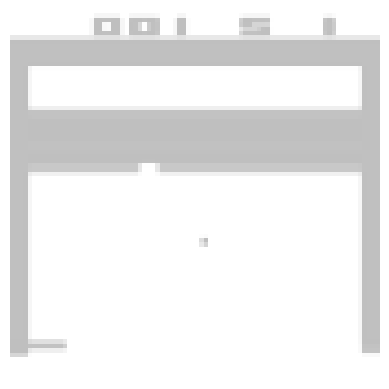

reward  0.0


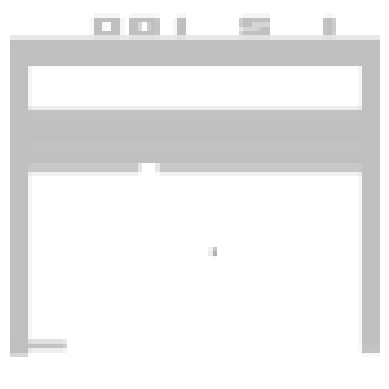

reward  0.0


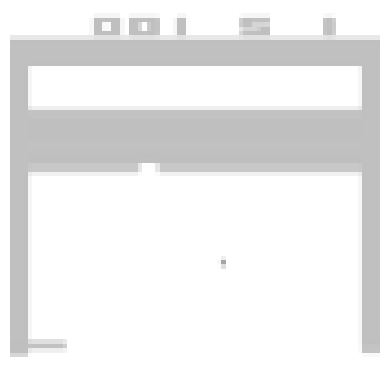

reward  0.0


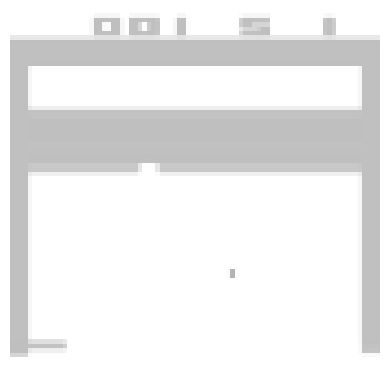

reward  0.0


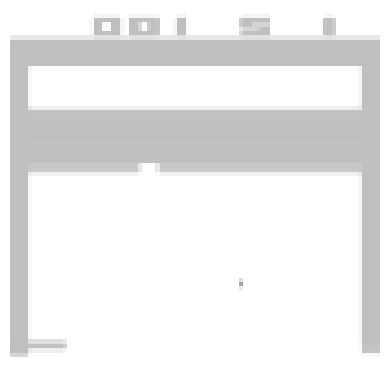

reward  0.0


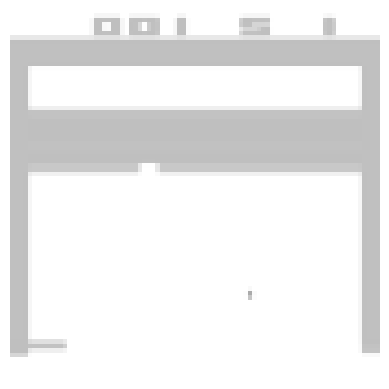

reward  0.0


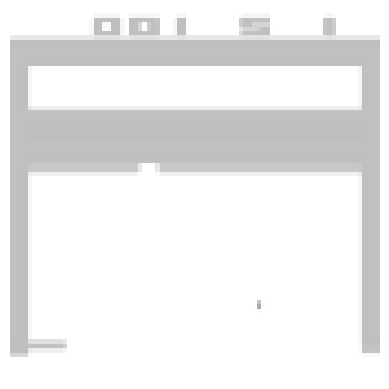

reward  0.0


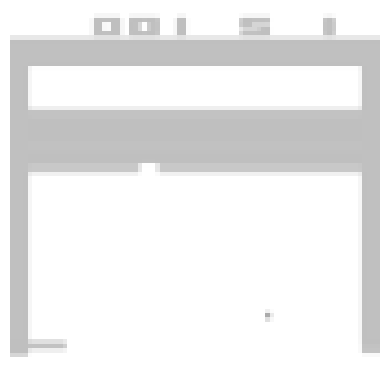

reward  0.0


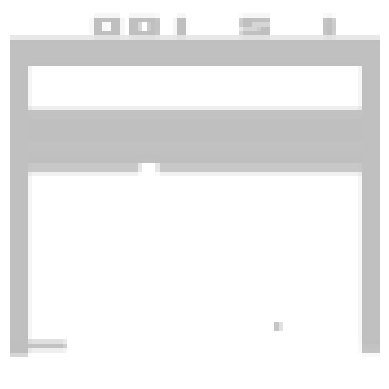

reward  0.0


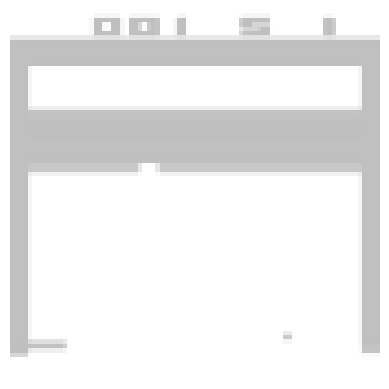

reward  0.0


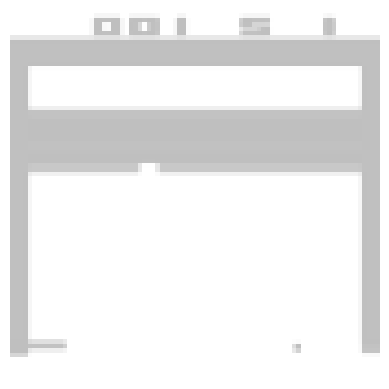

reward  0.0


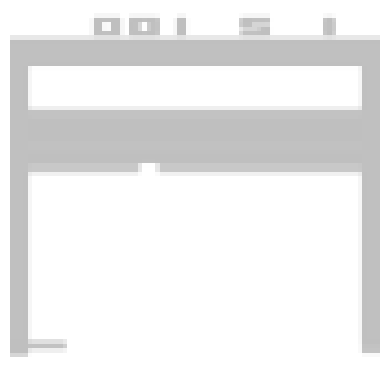

reward  0.0


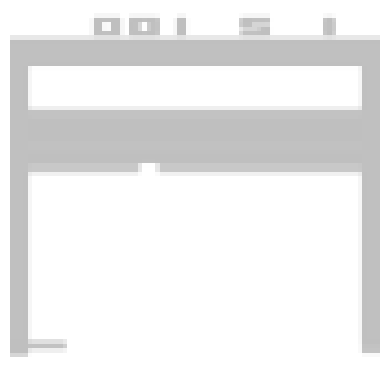

reward  0.0


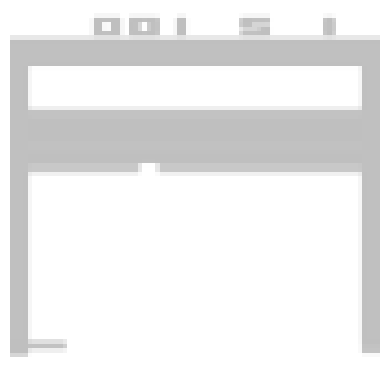

reward  0.0


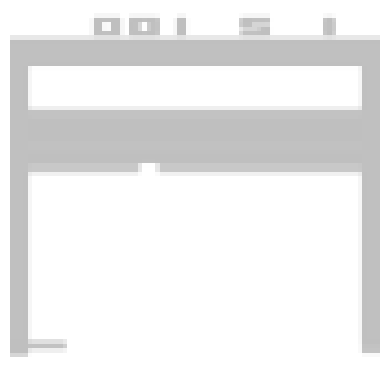

reward  0.0


[1.0]

In [15]:
def run_closed_loop(model, env, num_episodes=None):
    obs = env.reset()
    hx = model.get_initial_states()
    returns = []
    total_reward = 0
    while True:
        # add batch and time dimension (with a single element in each)
        plt.imshow(obs)
        plt.axis('off')
        plt.show()
        obs = np.expand_dims(np.expand_dims(obs, 0), 0)
        pred, hx = model.predict((obs, hx), verbose=0)
        action = pred[0, 0].argmax()
        # remove time and batch dimension -> then argmax
        obs, r, done, _ = env.step(action)
        print("reward ", r)
        total_reward += r
        if done:
            returns.append(total_reward)
            total_reward = 0
            obs = env.reset()
            hx = model.get_initial_states()
            # Reset RNN hidden states when episode is over
            if num_episodes is not None:
                # Count down the number of episodes
                num_episodes = num_episodes - 1
                if num_episodes == 0:
                    return returns

model3 = ConvCfC(env.action_space.n)

model3.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
model3.build((None, None, 84, 84, 4))
model3.load_weights("modelALETrial.h5")

env = gym.make("ALE/Breakout-v5")
env = wrap_deepmind(env)
run_closed_loop(model3, env, num_episodes=1)

In [16]:
tf.__version__

'2.11.0'

In [17]:
np.__version__

'1.23.5'